<a href="https://colab.research.google.com/github/BrainConnection/QuTiP/blob/main/Project%20Dynamic%20Decoupling/dispersive%20readout%20time%20dependent%20v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Basic parameters
D = 20 # dimension of Hilbert space (cavity)

omega_r = 2 * np.pi * 5.5  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 4.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.2        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01   # external coupling rate of resonator in units of GHz

tau = 200 # readout pulse length in units of ns

psi_g = basis(2, 0)
psi_e = basis(2, 1)
psi_p = (psi_g + psi_e) / np.sqrt(2)

a = tensor(qeye(2), destroy(D))
sm = tensor(destroy(2), qeye(D))
sp = sm.dag()

sx = sp + sm
sy = -1j * (sp - sm)
sz = sp * sm - sm * sp

The qubit-resonator system is described by the quantum Rabi model, whose Hamiltonian is given by
$$\hat{H} = \frac{\omega_q}{2}\hat{\sigma}_z + {\omega_r}\hat{a}^\dagger\hat{a} + g \hat{\sigma}_x (\hat{a} + \hat{a}^\dagger).$$
Here, $\omega_q$ and $\omega_r$ are the angular frequencies of the qubit and the readout resonator, respectively, and $g$ is the coupling rate.

In [ ]:
# quantum Rabi model
H = omega_q / 2 * sz + omega_r * a.dag() * a + g * sx * (a + a.dag())

We consider a time-dependent resonator drive of the form
$$\hat{H}_{r,d}(t) = A(t) (\hat{a} + \hat{a}^\dagger) \cos{(\omega_{r,d} t)}$$
to represent readout pulse that pumps photons inside the resonator.

In [ ]:
# time-dependent coefficient for drive
def Hrd_env(t, args):
    """
    Envelope function for the readout drive
    """
    A = args['A'] # amplitude of the readout drive
    T = args['T'] # duration of the readout drive, in units of ns

    return A * (0 <= t) * (t <= T)

def Hrd_coeff(t, args):
    omega_rd = args['omega_rd']
    return Hrd_env(t, args) * np.cos(omega_rd * t)

Note: Let us consider a case where the resonator is driven by such a drive with a constant amplitude $A_0$, i.e.,
$$\hat{H}_r (t) =\omega_r \hat{a}^\dagger \hat{a} + A_0 (\hat{a} + \hat{a}^\dagger) \cos{(\omega_{r,d} t)}.$$
We move to the frame rotating at the drive frequency of $\omega_{r,d}$ by performing the following transformation
$$\tilde{\hat{H}}_r = \hat{U}\hat{H}_r\hat{U}^\dagger + i\dot{\hat{U}}\hat{U}^\dagger,$$
where $\hat{U} = e^{i\omega_{r,d} t \hat{a}^\dagger\hat{a} }$. This gives
$$\tilde{\hat{H}}_r = (\omega_r - \omega_{r,d})\hat{a}^\dagger \hat{a} + \frac{A_0}{2}(\hat{a}e^{-i\omega_{r,d}t} + \hat{a}^\dagger e^{i\omega_{r,d}t})(e^{i\omega_{r,d}t} + e^{-i\omega_{r,d}t}) \approx (\omega_r - \omega_{r,d})\hat{a}^\dagger \hat{a} + \frac{A_0}{2}(\hat{a} + \hat{a}^\dagger ).$$


The Heisenberg equation of motion for $\hat{a}$, with an additional phenomenological term for decay, is given by
\begin{align*}
\dot{\hat{a}}(t) = \left[- i(\omega_r - \omega_{r,d}) - \frac{\kappa}{2}\right]\hat{a} - \frac{A_0}{2}.
\end{align*}
In the steady state, this gives the slowly-varying coherent state amplitude of
$$\alpha_{ss} = - \frac{A_0/2}{i(\omega_r - \omega_{r,d}) + \kappa/2}.$$
Therefore, the steady-state photon number is
$$
\bar{n}_{ss} = |\alpha_{ss}|^2 = \frac{(A_0 / 2)^2}{(\omega_r - \omega_{r,d})^2 + (\kappa / 2)^2 }
$$

In [ ]:
# list of times for numerical simulation (in units of ns)
tlist = np.linspace(0, 300, 1000)

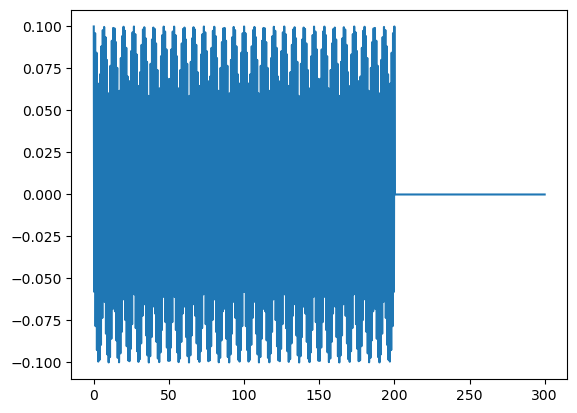

In [ ]:
plt.figure()
plt.plot(tlist, Hrd_coeff(tlist, {'A': 0.1, 'T': 200, 'omega_rd': omega_r}))

In [ ]:
A_drive = 0.05 * 2 * np.pi  # drive amplitude in units of GHz

In [ ]:
%%time
result0 = mesolve(
    [H, [a + a.dag(), Hrd_coeff]],
    tensor(basis(2, 0), basis(D, 0)),
    tlist,
    c_ops = [np.sqrt(kappa) * a],
    args = {'A': A_drive, 'T': 200, 'omega_rd': omega_r},
    e_ops = [a, a.dag() * a],
    options = Options(nsteps = 100000, rhs_reuse = True, atol = 1e-10, rtol = 1e-8)
)

CPU times: user 1min 5s, sys: 270 ms, total: 1min 5s
Wall time: 1min 5s


In [ ]:
%%time
result1 = mesolve(
    [H, [a + a.dag(), Hrd_coeff]],
    tensor(basis(2, 1), basis(D, 0)),
    tlist,
    c_ops = [np.sqrt(kappa) * a],
    args = {'A': A_drive, 'T': 200, 'omega_rd': omega_r},
    e_ops = [a, a.dag() * a],
    options = Options(nsteps = 100000, rhs_reuse = True, atol = 1e-10, rtol = 1e-8)
)

CPU times: user 1min 5s, sys: 289 ms, total: 1min 5s
Wall time: 1min 5s


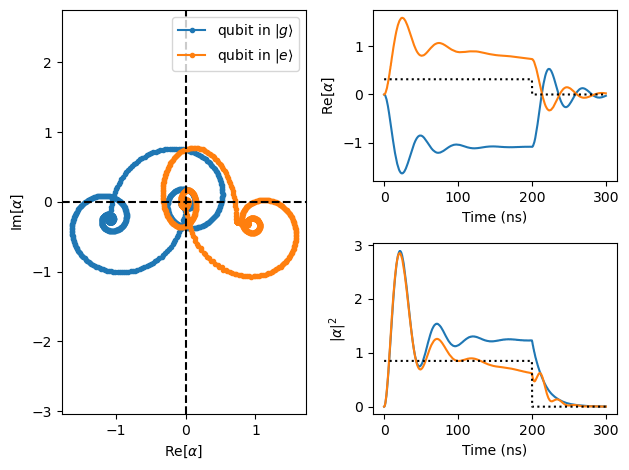

In [ ]:
# Plot Results
plt.figure()

plt.subplot(1, 2, 1)
alpha0 = result0.expect[0] * np.exp(1j * omega_r * tlist)
alpha1 = result1.expect[0] * np.exp(1j * omega_r * tlist)
plt.plot(alpha0.real, alpha0.imag, '.-', label=r'qubit in $|g\rangle$')
plt.plot(alpha1.real, alpha1.imag, '.-', label=r'qubit in $|e\rangle$')
plt.xlabel(r'Re[$\alpha$]')
plt.ylabel(r'Im[$\alpha$]')
plt.axvline(0.0, color='black', ls='--')
plt.axhline(0.0, color='black', ls='--')
plt.legend()
plt.axis('equal')

plt.subplot(2, 2, 2)
plt.plot(tlist, alpha0.real)
plt.plot(tlist, alpha1.real)
plt.xlabel('Time (ns)')
plt.ylabel(r'Re[$\alpha$]')
plt.plot(tlist, Hrd_env(tlist, {'A': A_drive, 'T': 200}), color='black', ls=':')

plt.subplot(2, 2, 4)
plt.plot(tlist, np.abs(alpha0) ** 2)
plt.plot(tlist, np.abs(alpha1) ** 2)
plt.xlabel('Time (ns)')
plt.ylabel(r'$|\alpha|^2$')
plt.plot(tlist, Hrd_env(tlist, {'A': (A_drive / 2) ** 2 / ((g ** 2 / np.abs(omega_r - omega_q)) ** 2 + (kappa / 2) ** 2), 'T': 200}), color='black', ls=':')

plt.tight_layout()

The ring-up and ring-down of resonator take place at the rate of $\kappa^{-1}$

In [ ]:
1 / kappa # in units of ns

15.915494309189533